<a href="https://colab.research.google.com/github/hritik7080/Reddit-Flair-Detection/blob/master/Reddit_flair_detection_EDA%2BModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I - Reddit Data Collection

Installing praw library to use the Reddit Data Collection api.

In [1]:
!pip install praw

Importing praw library and initializing the reddit api by passing credentials as arguments.

In [0]:
import praw
reddit = praw.Reddit(client_id="Use_Yours", client_secret='Use_Yours', user_agent='Use_Yours')

Set the subreddit to India because we want all of the posts should be from India.

In [0]:
subreddit = reddit.subreddit('india')

Making a list of flairs that we want.

In [0]:
flairs = ["AskIndia", "Scheduled", "Photography", "Science/Technology", "Politics", "Business/Finance", "Policy/Economy", "Sports", "Food", "AMA"]

Storing atmost 220 posts of each flair in a list and then typecasting the list to a pandas DataFrame with relevant column names and printing the DataFrame's shape.

***Experiment:*** Previously I was taking atmost 1000 posts of each flair, but the API doesn't provided these many posts. It provided random number of posts for each flair like 240 posts for ASKINDIA 205 posts for PHOTOGRAPHY. This can create biasness in our deep learning model that's why I took atmost 220 posts so that I can get exactly 220 posts for almost all falirs

In [4]:
import pandas as pd
posts=[]
for flair in flairs:
  
  get_subreddits = subreddit.search(flair, limit=220)
  for post in get_subreddits:
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created, flair])
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created', 'flair'])
print(posts.shape)

(2193, 9)


# Part II - Exploratory Data Analysis (EDA)

Importing necessary libraries

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Checking the number of posts of each flair

In [6]:
posts['flair'].value_counts()

Photography           220
Sports                220
AskIndia              220
Food                  220
Politics              220
Policy/Economy        220
Science/Technology    220
Business/Finance      220
Scheduled             220
AMA                   213
Name: flair, dtype: int64

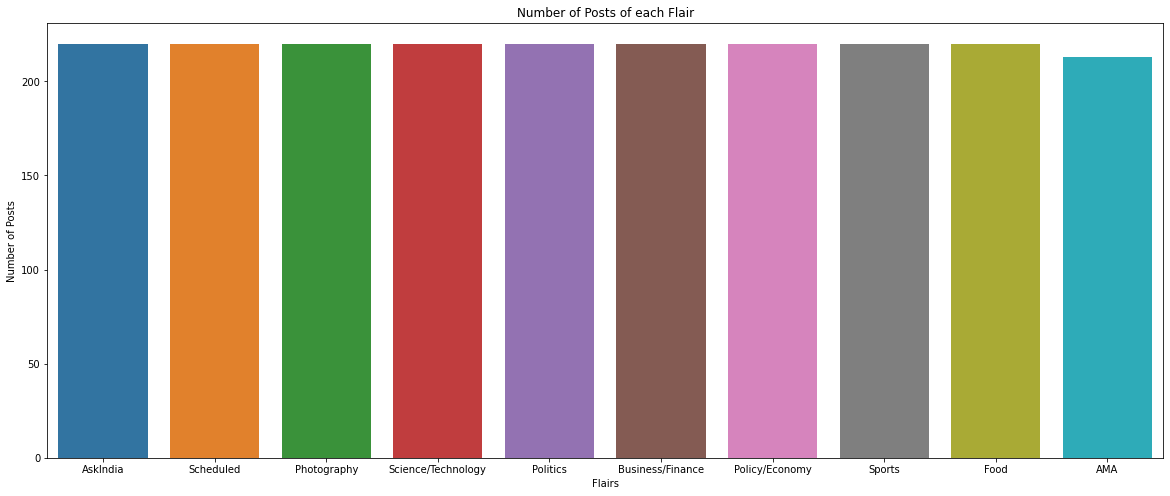

In [7]:
plt.figure(figsize=(20,8))
sns.countplot(x='flair', data=posts)
plt.title("Number of Posts of each Flair")
plt.xlabel('Flairs')
plt.ylabel("Number of Posts")
plt.show()

The data is almost equally distributed

Checking the average number of comments on the posts in the dataset

In [8]:
posts['num_comments'].sum()/posts.shape[0]

65.56452348381212

Making a Histogram to check the Comment Distribution for the posts in the dataset

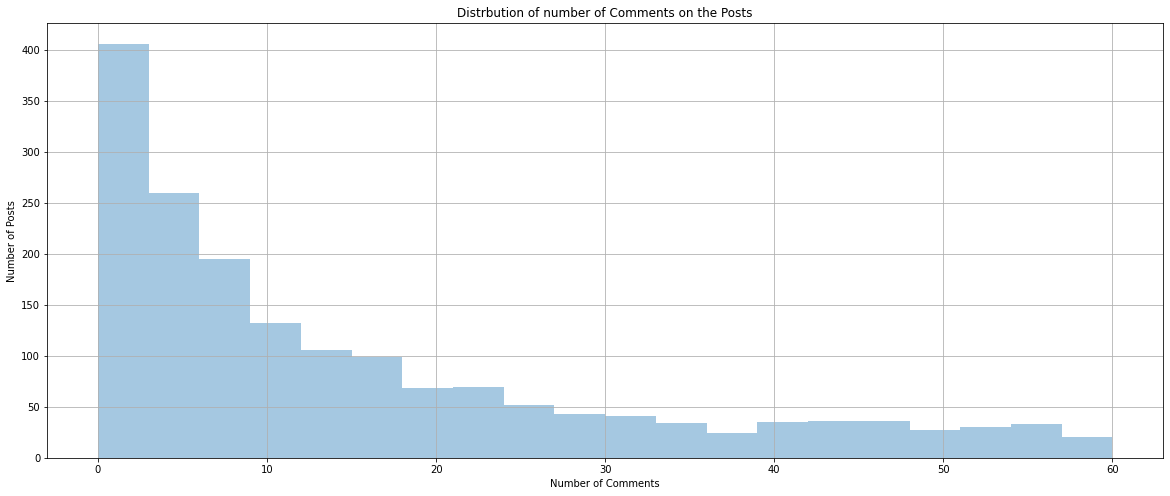

In [9]:
plt.figure(figsize=(20,8))
sns.distplot(posts[posts["num_comments"] < 61]["num_comments"], kde=False)
plt.grid()
plt.title("Distrbution of number of Comments on the Posts")
plt.ylabel("Number of Posts")
plt.xlabel("Number of Comments")

plt.show()

According to the above graph most of the posts are having atmost 10 comments in the dataset

Checking the average number of scores on the posts in the dataset

In [10]:
posts['score'].sum()/posts.shape[0]

157.04286365709075

Making a Histogram to check the Score Distribution for the posts in the dataset

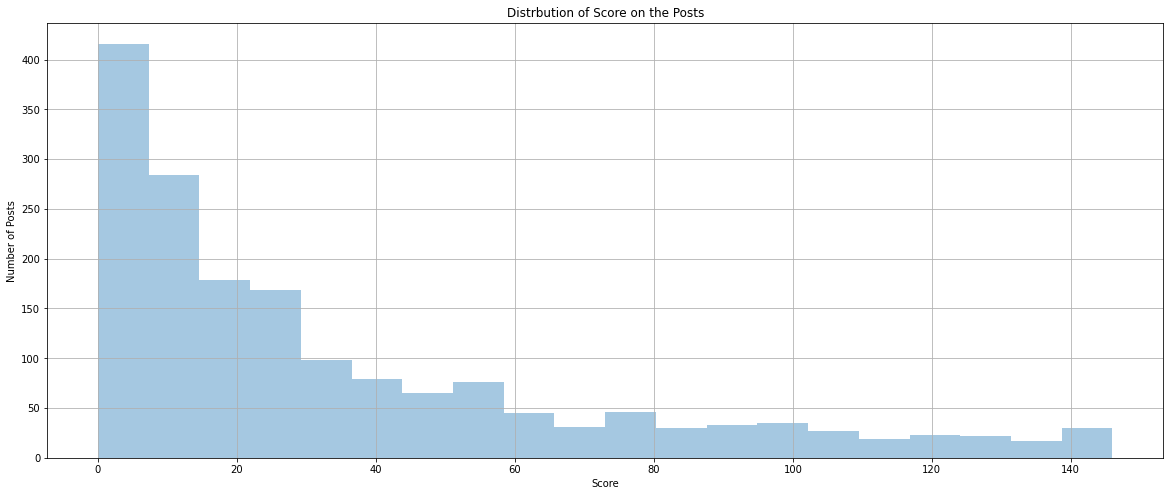

In [11]:
plt.figure(figsize=(20,8))
sns.distplot(posts[posts["score"] < 147]["score"], kde=False)
plt.grid()
plt.title("Distrbution of Score on the Posts")
plt.ylabel("Number of Posts")
plt.xlabel("Score")

plt.show()

It is clearly visible that most of the posts contains atmost 30 score in the dataset.

Showing top 15 posts having highest number of comments

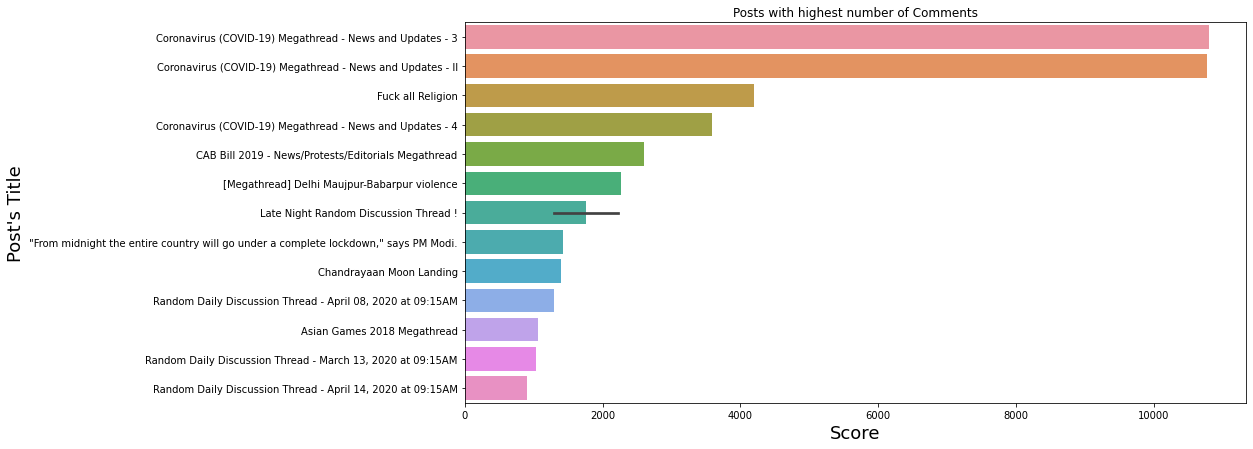

In [12]:
data_score = posts.sort_values('num_comments', ascending=False).head(15)
plt.figure(figsize=(14,7))
plt.title("Posts with highest number of Comments")
sns.barplot(y=data_score['title'],x=data_score['num_comments'])
plt.xlabel('Score',fontsize=18)
plt.ylabel("Post's Title",fontsize=18)
plt.show()

Shwoing top 15 posts having highest score

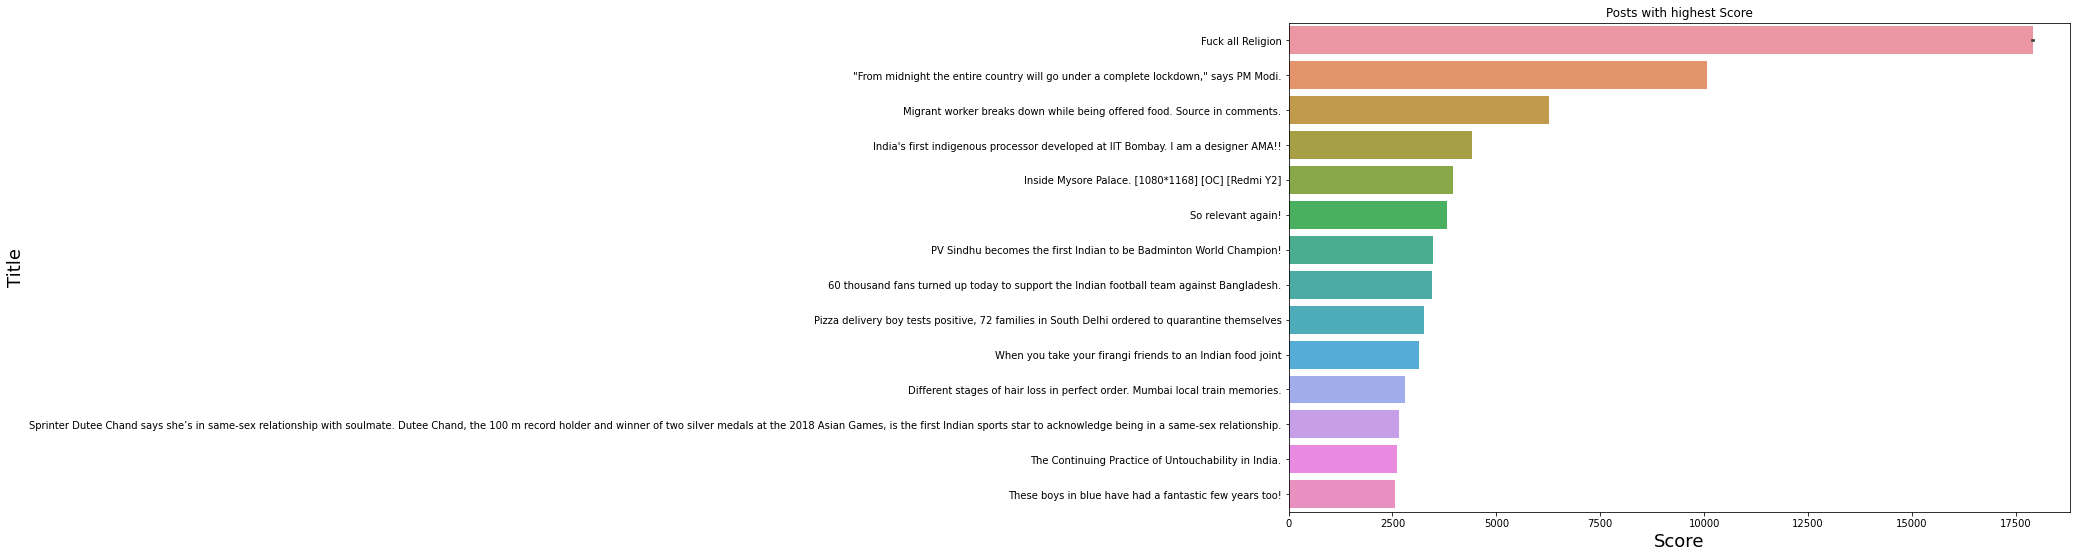

In [13]:
data_score = posts.sort_values('score', ascending=False).head(15)
plt.figure(figsize=(14,9))
plt.title('Posts with highest Score')
sns.barplot(y=data_score['title'],x=data_score['score'])
plt.xlabel('Score',fontsize=18)
plt.ylabel('Title',fontsize=18)
plt.show()

Let's check that more number of Comments results more score or not i.e, does these factors relates each other. For this I'll first find the correlation mactrix of columns than plot a heatmap.

In [14]:
correlation =  posts.corr()
correlation

score  num_comments   created
score         1.000000      0.352306  0.073652
num_comments  0.352306      1.000000  0.014948
created       0.073652      0.014948  1.000000

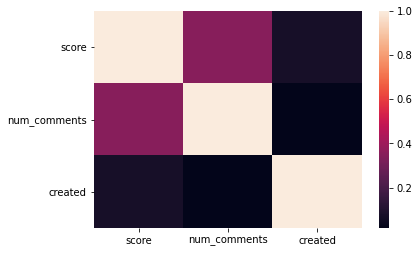

In [15]:
sns.heatmap(correlation)
plt.show()

Here we can see that there is a small positive correlation of 0.3 between score and number of comments. That mean there is a little bit relation between these columns but do not completly dependent upon each other.

Now lets check the most occured words in the title of each flair. I am plotting the wordcloud which shows the mostly occured word with biggest font size and least occured word with smallest font size.

before that lets make a set of stopwords which are not needed to detect the flair of a sentence.

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

Plotting the Wordclouds of each flair.

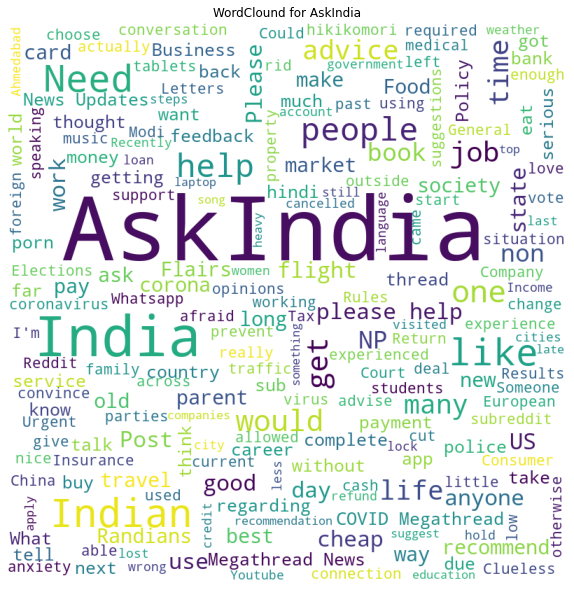

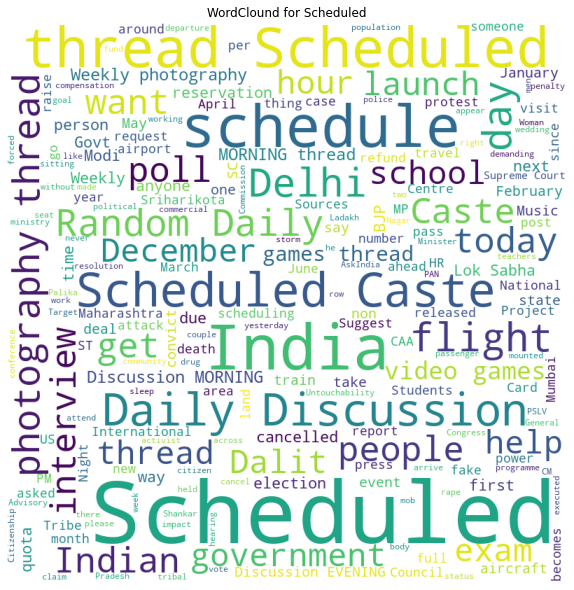

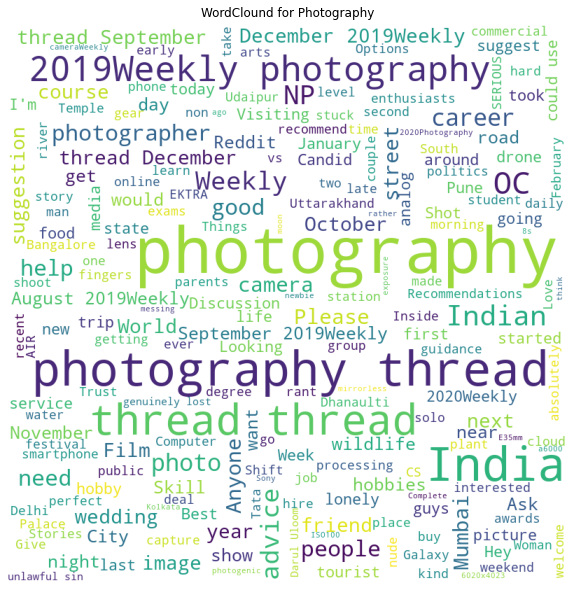

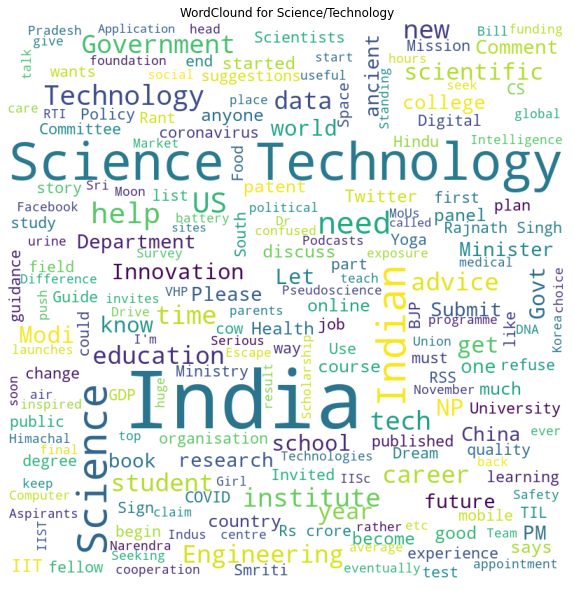

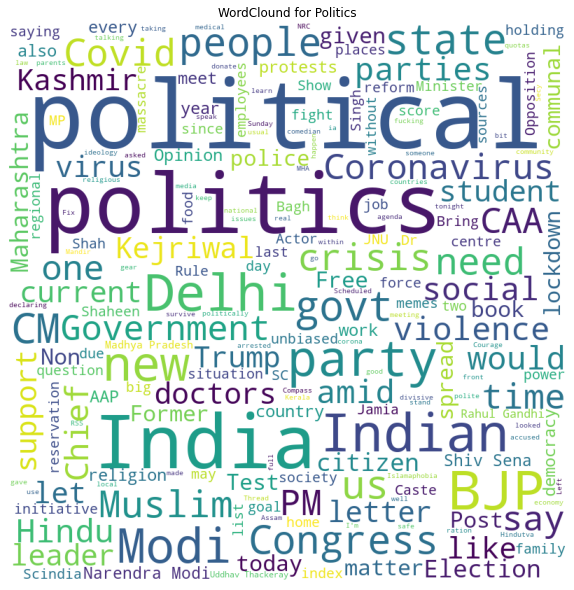

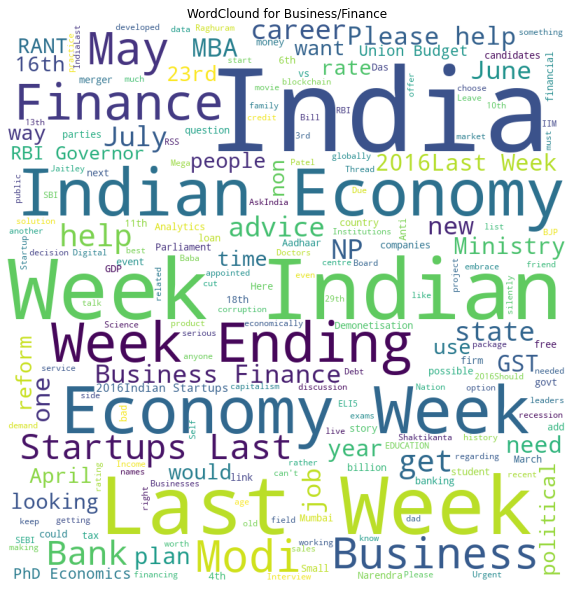

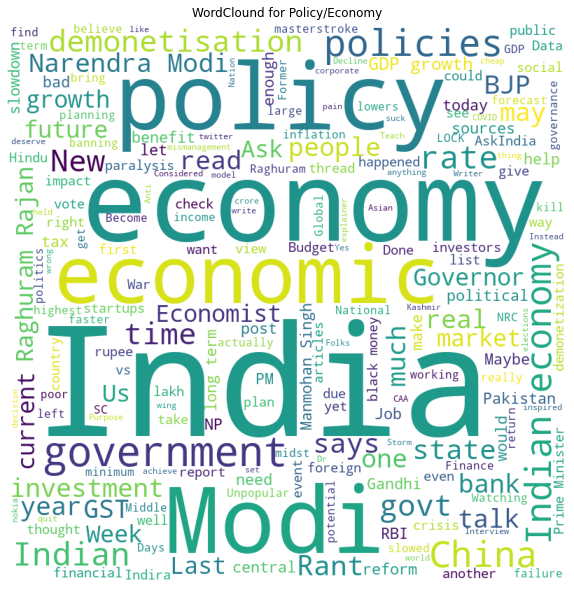

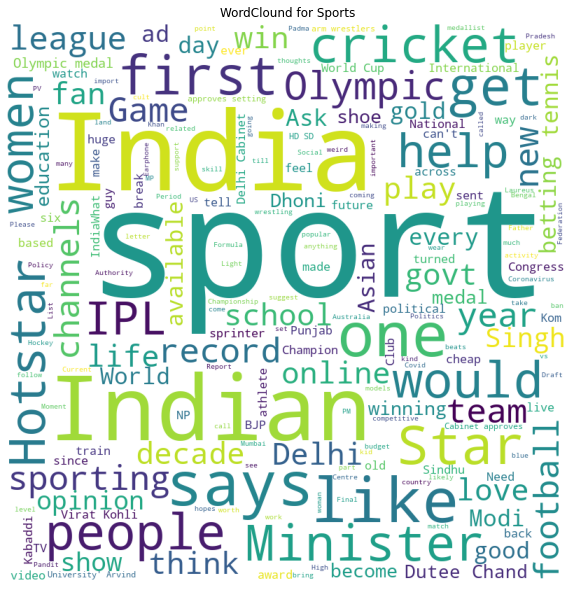

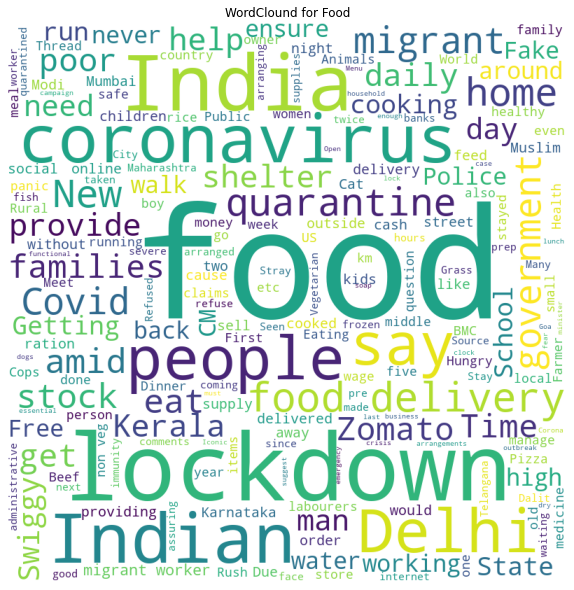

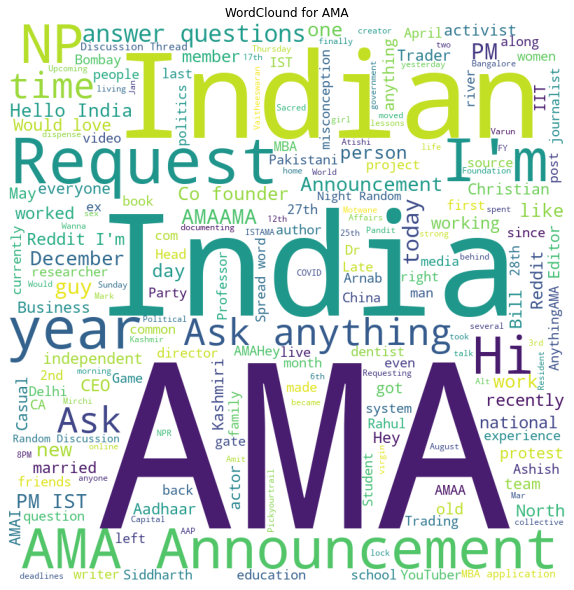

In [18]:
from wordcloud import WordCloud, STOPWORDS 
for flair in flairs:
  content = ""
  for i in posts[posts['flair']==flair]['title']:
    content+=i
  wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop, min_font_size = 10).generate(content)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.title("WordClound for "+flair)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  plt.show() 

# Part III - Buiding a Flare Detector

Before making a Deep Learning model, I have to choose the more relevant words that can be used to classify easily and also I have to convert the text data into vectors so that I can feed the data to the model for training.

### I am going to classify the posts by checking the title the post.

Making a function to remove noise i.e, unwanted data from our dataset. This function is doing following tasks: 


1.   Converting each and every word or letter to lower case
2.   Removing Extra Whitespaces
3.   Removing words inside brackets like [OC], [ASKINDIA] etc.
4.   Removing every character which is non alphanumeric. 
5.   Limmatizing the data.It is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Such as "good better" becomes "good good".
6.   Removing stopwords like "if", "here", "there" etc. which are not needed to classify the sentences.<br>
By using these steps we can reduce the redundancy and the size of data so that our model get trained on a relevant data.







In [19]:
import nltk
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
def remove_noise(text):

    # Step1: Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Step2: Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Step3 : Removing words inside brackets like "[OC]"
    text = text.apply(lambda x: re.sub(r"\[.*?\]", "", x))

    # Step4 : Removing everything from the data which is not alphanumeric.
    text = text.apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

    # Step5 : Lemmatization
    lm=WordNetLemmatizer()
    text = text.apply(lambda x: lm.lemmatize(x))
    
    # Step6 : Removing Stopwords
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Convert to string
    text = text.astype(str)
        
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Removing noise from the Title feature of the dataset

In [0]:
posts['title'] = remove_noise(posts['title'])

In [21]:
posts['title']

0       4 days ago pending orders 100 million hydroxyc...
1       randians big time users dating apps like tinde...
2                             rindia thinks flat earthers
3       people left 9 5 jobs pursue career music art f...
4                          somebody want kill full family
                              ...                        
2188    exchristian convert spent 20 years system chri...
2189    rindiainvestments ama gaurav rastogi neelabh s...
2190                         ama request raghuram g rajan
2191    ama got selected pradhan sevak first day fourt...
2192    hi rindia rajeev chandrasekhar member rajya sa...
Name: title, Length: 2193, dtype: object

Currently our data is in a sequence like first there are 220 posts of ASKINDIA then 220 posts of PHOTOGRAPHY. This won't work while training the data so we have to shuffle it.

In [0]:
# Shuffling
posts = posts.sample(frac=1)

Now I am going to convert the text data into integer vectors. First I'll split each sentence by space and then assign a number to each distinct words.<br>
For Example:<br>
"Where are you going" ---> ["Where", "are", "you", ""going"] ---> [12, 43, 5, 34]

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(posts['title'].values)

Using TensorFlow backend.


In [0]:
sequences = tokenizer.texts_to_sequences(posts['title'].values)

Now our sentence are converted to int vectors but they are of different length because every sentence had different number of words. The data should be structured correctly so that it can be feed into the Deep Learning model.

To make each vector of same length I'll use padding.
That means,<br>
Suppose the maximum length of a vector is set to 8.<br>
We have 3 vectors of different length.<br>
 [195, 18, 158, 365],<br>
 [1073, 787, 196, 614, 2608, 1074],<br>
 [507, 23, 419, 253],<br>
 After padding it will look like:<br>
 [0, 0, 0, 0, 195, 18, 158, 365],<br>
 [0, 0, 1073, 787, 196, 614, 2608, 1074],<br>
 [0, 0, 0, 0, 507, 23, 419, 253],<br>
 Now the lenght of all three of them is 8.


Saving the tokenizer for further usage in other files for webapplication

In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

To set the maximum length of the sentence I am going to check the distribution of length of senteces in the  title feature of the dataset.

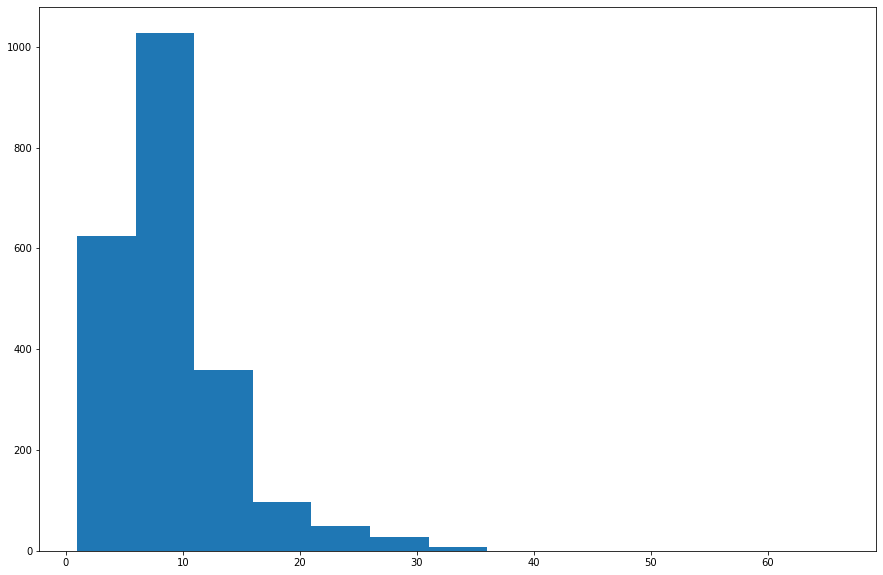

In [25]:
totalNumWords = [len(one_comment) for one_comment in sequences]
plt.figure(figsize=(15, 10))
plt.hist(totalNumWords, bins=[i for i in range(1,70, 5)])
plt.show()

Here we can see that there is not any post's title having length more than 50.

In [0]:
# Padding
MAX_LEN = 50
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN)

In [27]:
padded_sequences

array([[   0,    0,    0, ...,  609,   16,  357],
       [   0,    0,    0, ...,  120,   31, 2565],
       [   0,    0,    0, ...,   14,  418, 2566],
       ...,
       [   0,    0,    0, ...,   53,  122,  249],
       [   0,    0,    0, ..., 6398, 6399, 6400],
       [   0,    0,    0, ...,  298, 6401,    4]], dtype=int32)

Initializing my kaggle account to download a word embedding of FastText Crawl by Facebook.


In [28]:
import os
os.environ['KAGGLE_USERNAME'] = "Use_Yours"
os.environ['KAGGLE_KEY'] = "Use_Yours"
!kaggle datasets download -d yekenot/fasttext-crawl-300d-2m

 99% 1.43G/1.44G [00:12<00:00, 221MB/s]
100% 1.44G/1.44G [00:13<00:00, 119MB/s]


Data will be downloaded in zip format so I have to unzip it.

In [29]:
!unzip /content/fasttext-crawl-300d-2m.zip

Archive:  /content/fasttext-crawl-300d-2m.zip
  inflating: crawl-300d-2M.vec       


In NLP tasks Embeding Layer would be the first hidden layer of the model.<br>
Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. <br>
The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.<br>
A word embedding is an approaches for representing words and documents using a dense vector representation.<br>
Here I am not lettting the Embedding Layer to initialize it's random weights. I am using a ***TRANSFER LEARNING*** approach to train the model.

The FastText Carwl word embedding that I downloaded from Kaggle are pre-trained word embeddings trained and released by Facebook after training on 2 million words. The size of embedding is 4GB.

Pretrained Word Embeddings are the embeddings learned in one task that are used for solving another similar task.

This FastText crawl embedding is trained on large datasets, saved, and then I am using it for solving other tasks. That’s why pretrained word embeddings are a form of **Transfer Learning**.<br>
Transfer learning, as the name suggests, is about transferring the learnings of one task to another. 


In [0]:
# Link to 2 million word vectors trained on Common Crawl (600B tokens)
embedding_path = '/content/crawl-300d-2M.vec'

This Embedding is 300-dimnesional.

Setting embedding size & max number of features


In [0]:
embed_size = 300
max_features = 30000

Here I am preparing the Embedding Matrix for the model by the FastText embedding.

In [0]:
import numpy as np
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: 
        
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(6402, 300)

Now I am going to encode output column(flair) using One Hot Encoding. This is where the words like ASKINDIA, AMA etc is removed and a new binary variable is added for each unique value.

In [0]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(posts['flair'].values.reshape(-1, 1))

In [35]:
y_ohe

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

These are all the categories in the dataset

In [36]:
ohe.categories_

[array(['AMA', 'AskIndia', 'Business/Finance', 'Food', 'Photography',
        'Policy/Economy', 'Politics', 'Scheduled', 'Science/Technology',
        'Sports'], dtype=object)]

Saving the ohe object for further usage in other files.

In [0]:
import pickle

# saving
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(ohe, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Lets start building the model

**Experiments:** Firstly I tried some sequential models with only 4 LSTM layers but the accuracy was not good and then I tried using LSTMs with a Bidirectional LSTMs but it didn't worked. Then I tried with hybrid models like CNN-LSTMs and aslo with CNN+LSTM+Bidirectional_LSTM but the accuracy was arround 60%. Then I moved to non sequential models and tried different combinations of layers and finally made this model with ***94%*** accuracy.

Importing all the Necessary Libraries

In [0]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

One of the function uses tensorflow.contrib module which is not in latest version of tensorflow, so I am intalling tensorflow 1.15

In [38]:
!pip install tensorflow==1.15

Initializing the file path for best model and Checkpoint to save the model whenever the validation accuarcy improves.

In [0]:
file_path = "best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                              save_best_only = True, mode = "max")

Defining an early stop with patience=25, that means if the validation accuracy didn't improved in last 25 epochs that model will stop training.

In [0]:
early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 25)

check_point and early_stop are be known as model callbacks.

Creating a function build_model that contains all the layers of our non-sequential fully connected Deep Learning model.

In [0]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (50,))
    x = Embedding(embedding_matrix.shape[0], embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)
    global history
    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(128,activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(100,activation='relu') (x))
    x = Dense(10, activation = "sigmoid")(x)
    
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(padded_sequences, y_ohe, batch_size = 128, epochs = 200, validation_split=0.3, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    import matplotlib.pyplot as plt
    print(history.history.keys())
   
    
    return model

I am using both GRU and LSTM layers in the model. GRU use less training parameters and therefore use less memory, execute faster and train faster than LSTM's whereas LSTM is more accurate on dataset using longer sequence. Both layers can be helpful in the NLP related task. 

For Validation I am splitting 30% of data. That means model will 
train on 1534 samples, validate on 658 samples

In [42]:
# Instantiating model
model = build_model(lr = 1e-4, lr_d = 0, units = 128, dr = 0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1535 samples, validate on 658 samples
Epoch 1/200
1535/1535 [==============================] - 11s 7ms/step - loss: 0.8666 - accuracy: 0.4723 - val_loss: 0.6981 - val_accuracy: 0.4150

Epoch 00001: val_accuracy improved from -inf to 0.41505, saving model to best_model.hdf5
Epoch 2/200
1535/1535 [==============================] - 2s 2ms/step - loss: 0.8082 - accuracy: 0.5042 - val_loss: 0.6896 - val_accuracy: 0.5038

Epoch 00002: val_accuracy improved from 0.41505 to 0.50380, saving model to best_model.hdf5
Epoch 3/200
1535/1535 [==============================] - 2s 2ms/step - loss: 0.7636 - accuracy: 0.5377 - val_loss: 0.6815 - val_accuracy: 0.5751

Epoch 00003: val_accuracy improved from 0.50380 to 0.57508, saving model to best_model.hdf5
Epoch 4/200
1535/1535 [==============================] - 2s 2ms/s

Vizualizing the loss and accuracy or training and validation in each epoch.

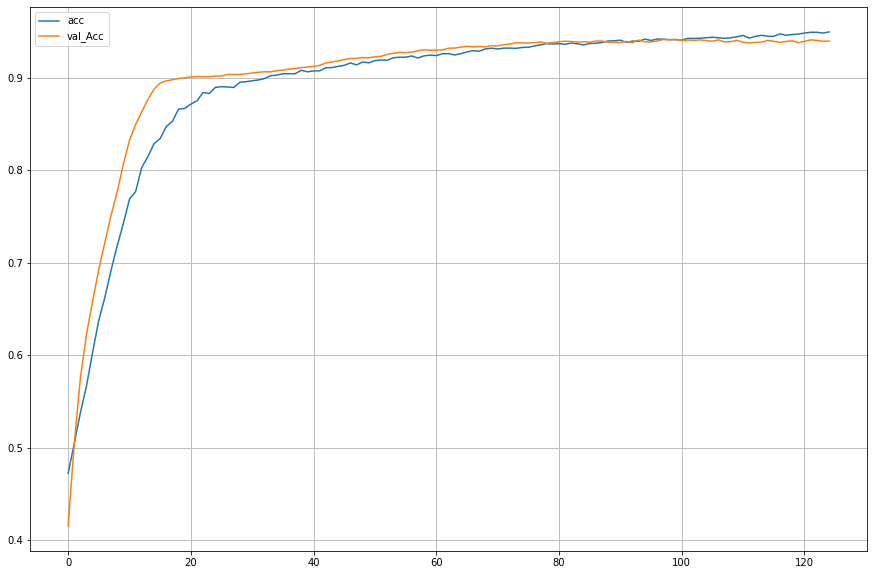

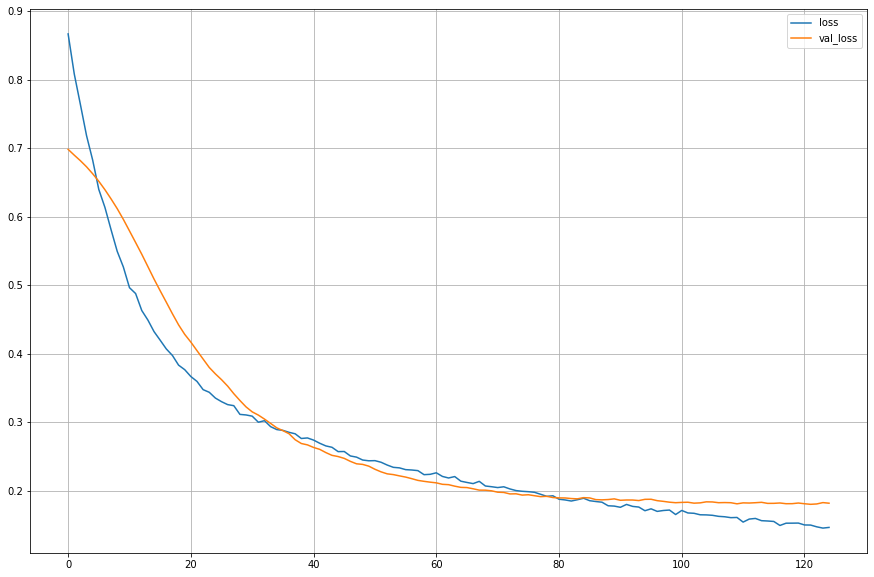

In [43]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label="acc")
plt.plot(history.history['val_accuracy'], label="val_Acc")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.grid()
plt.legend()
plt.show()

Plotting the model to show all the layers and flow of my Neural Network.

### The final validation accracy is 94.2% and validation loss is 0.16

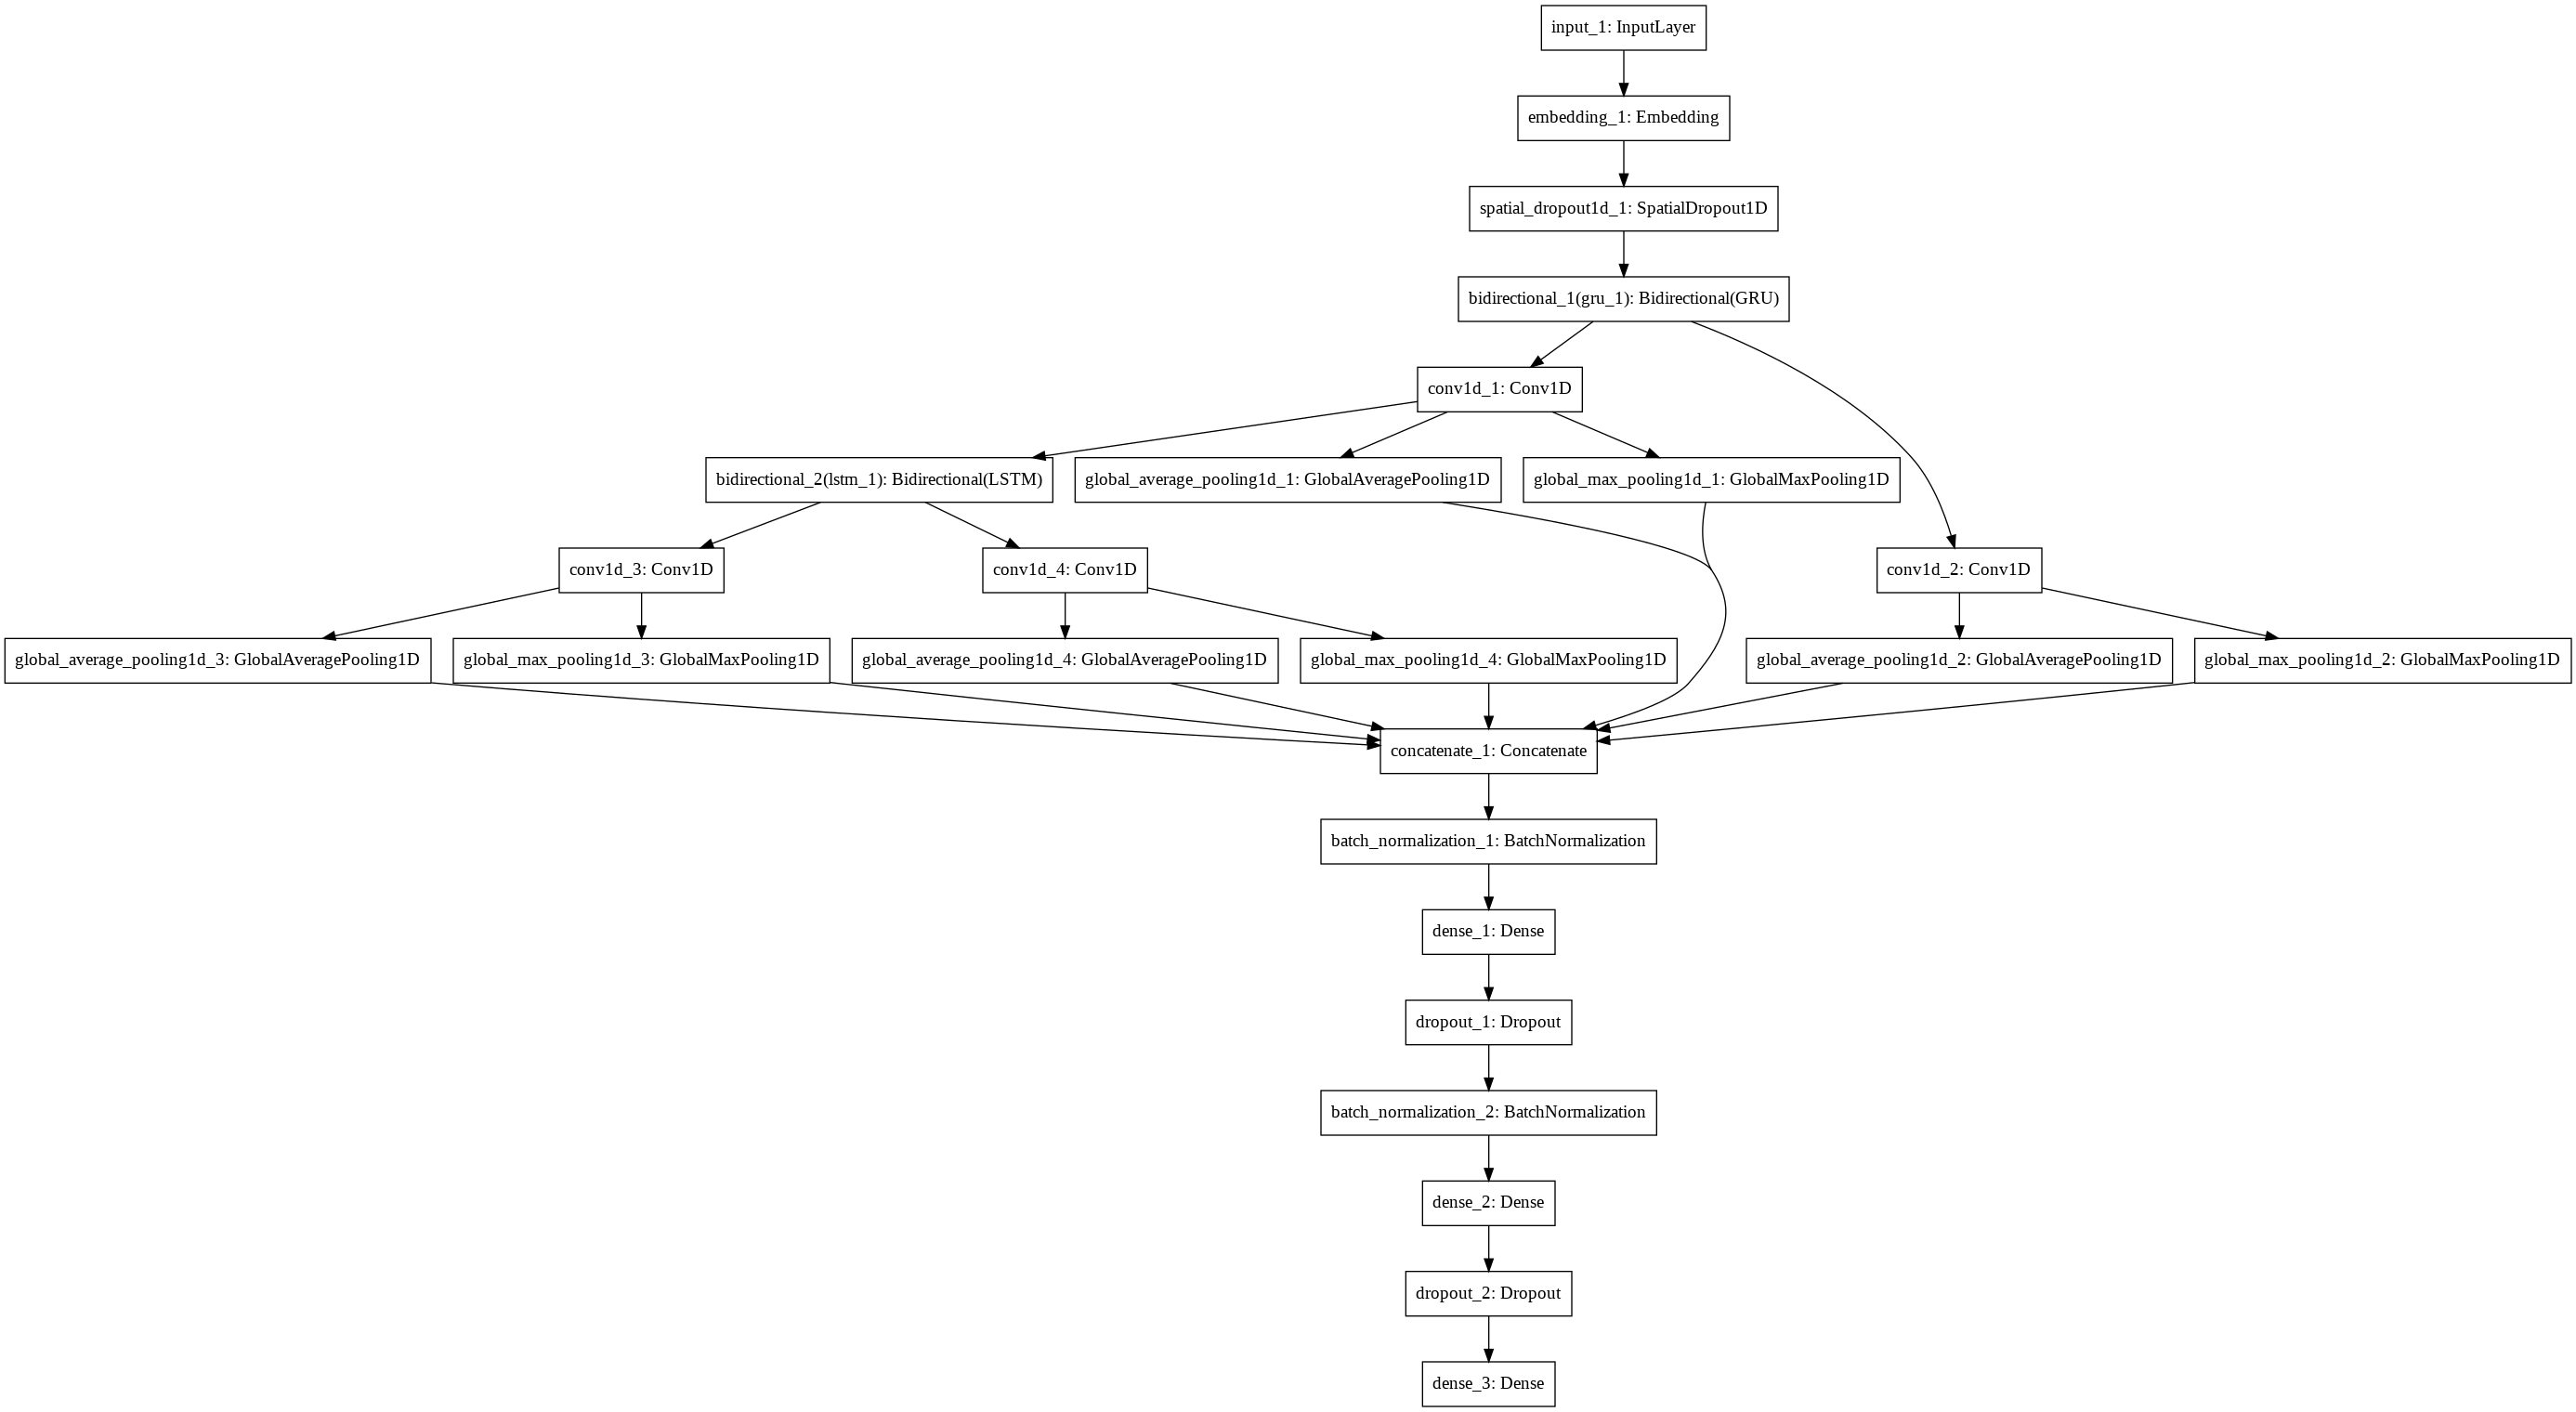

In [44]:
from keras.utils import plot_model
plot_model(model, to_file='./model.png')

In [0]:
def remove_noise_test(x):
  text = [" ".join(x.lower() for x in x[0].split())]
  text = [" ".join(x.strip() for x in text[0].split())]
  text = [" ".join(x for x in text[0].split() if x not in stop)]
  text = [re.sub(r"\[.*?\]", "", text[0])]
  text = [re.sub('[^a-zA-Z0-9\s]', '', text[0])]
  lm=WordNetLemmatizer()
  text = [lm.lemmatize(text[0])]
  text = tokenizer.texts_to_sequences(x)
  text = pad_sequences(text, maxlen=50, dtype='int32', value=0)
  return text


Here I am copying some real Reddit posts and cross checking the flair.

In [53]:
x = ["State Visit of Prime Minister Gandhi of India. President Reagan's Speech and Prime Minister Gandhi's Speech at Arrival Ceremony, South Lawn on July 29, 1982"]

text = remove_noise_test(x)

ans = model.predict(text, batch_size=1, verbose=2)

ohe.categories_[0][ans[0].argmax()]

'Politics'

This one was correct.

In [54]:
x = ["You know what the worst part is?"]

text = remove_noise_test(x)

ans = model.predict(text, batch_size=1, verbose=2)

ohe.categories_[0][ans[0].argmax()]

'AskIndia'

This actual flair was Politics but it is showing AskIndia because it doesn't have any

In [47]:
x = ["Holy river Ganges self-cleared during lockdown. This was shot at Triveni Ghat, Rishikesh, Uttarakhand."]

text = remove_noise_test(x)

ans = model.predict(text, batch_size=1, verbose=2)

ohe.categories_[0][ans[0].argmax()]

'Photography'

This one is predicted correctly

In [48]:
x = ["without otp can somebody get my loan /cibil details"]

text = remove_noise_test(x)

ans = model.predict(text, batch_size=1, verbose=2)

ohe.categories_[0][ans[0].argmax()]

'AskIndia'

This one predicted correctly

### Although my Model doesn't predict correctly always because of the lack of data. I am using only 2100 sentences to train the model which is not enough. If we provide it more data accuracy may increase.

## ***NOTE:*** On the current dataset my model's validation accuracy is 94.2% with validation loss of 0.16